### Building a dataset for a heat metric: 
1. Loading our data - [link](#1)
2. Using OSMNX to extract bikeways as nodes and edges - [link](#2)
3. Train a regression model to estimate missing featured - [link](#3)
4. Using buffers, build polygons for our streets - [link](#4)
5. Build a raster cropping function - [link](#5)
6. Build calculation functions for our three raster images - [link](#6)
7. Apply to the dataframe, relabel columns to make a valid geodataframe, plot for fun - [link](#7)


### 0. Imports

In [5]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio import features
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import geopandas as gpd
from collections import Counter
from tqdm.notebook import tqdm
import osmnx as ox
from pyproj import Proj
from pyproj import Transformer
from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely import buffer
from functools import partial
import pyproj
from shapely.ops import transform
import re
import os


<a id=1></a>
### 1. Load the Data

#### 1.1 Loading our shadow raster
This will be the base of our analysis

In [6]:
#open the raster file
raster = rasterio.open('Schaduw op loopgebieden - Gemeente Amsterdam.tiff')
#make sure we have the correct projection
assert raster.crs == {'init': 'epsg:28992'}
image = raster.read(1)

We need the bounds of our shadow raster to know which bikeways to retrieve using OSMNX in the next step.

OSMNX needs our coordinates to be in WGS84 coordinate format, so we need to calculate a reprojection

In [7]:
bounds = raster.bounds
print(bounds)

#reproject to WGS84
transformer = Transformer.from_crs("epsg:28992", "epsg:4326")
minx, miny = transformer.transform(bounds.left, bounds.bottom)
maxx, maxy = transformer.transform(bounds.right, bounds.top)

#swap x and y
minx, miny, maxx, maxy = miny, minx, maxy, maxx

BoundingBox(left=108516.66241091306, bottom=475228.9412945604, right=135638.8010029708, top=495428.4724188188)


#### 1.2 Load perceived temperature and urban heat island raster
These data were collected from the Klimaateffectatlas

In [13]:
# load perceived temperature tif
temp_raster = rasterio.open('../heat_metric/klimaateffectatlas/Hittekaart gevoelstemperatuur Huidig.tif')
#make sure we have the correct projection
assert temp_raster.crs == {'init': 'epsg:28992'}
temp_image = temp_raster.read(1)


In [14]:
# load urban heat island tif
uhi_raster = rasterio.open('../heat_metric/klimaateffectatlas/Stedelijk hitte eiland effect.tif')
#make sure we have the correct projection
assert uhi_raster.crs == {'init': 'epsg:28992'}
uhi_image = uhi_raster.read(1)

<a id=2></a>
### 2. Extracting bikeways with OSMNX

In [8]:
ox.settings.default_crs = "epsg:4326"
ox.settings.log_file = True
ox.settings.useful_tags_way = [
    'oneway',
    'highway',
    'lanes',
    'reversed',
    "name",
    
    "maxspeed",
    
    "area",
    "width",
    "est_width",
    
    "surface",
    "lit",
    "smoothness",
    
]

G = ox.graph_from_bbox(maxy, miny, maxx, minx, network_type='bike', simplify=False, retain_all=True)
#reproject
G = ox.project_graph(G, to_crs="epsg:28992")

G

<a id=3></a>
### 3. Predict width and surface types using neural networks

First, convert our street graph to a geodataframe

In [9]:
streets_df = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
streets_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 489827 entries, (6316199, 1360288038, 0) to (11510781682, 11510781681, 0)
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   osmid       489827 non-null  int64   
 1   oneway      489827 non-null  bool    
 2   highway     489827 non-null  object  
 3   name        285057 non-null  object  
 4   width       98898 non-null   object  
 5   surface     228984 non-null  object  
 6   lit         113425 non-null  object  
 7   smoothness  115309 non-null  object  
 8   reversed    489827 non-null  bool    
 9   length      489827 non-null  float64 
 10  maxspeed    195630 non-null  object  
 11  lanes       77363 non-null   object  
 12  est_width   624 non-null     object  
 13  area        34 non-null      object  
 14  geometry    489827 non-null  geometry
dtypes: bool(2), float64(1), geometry(1), int64(1), object(10)
memory usage: 73.8+ MB


c:\Users\Sahir\anaconda3\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Sahir\anaconda3\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


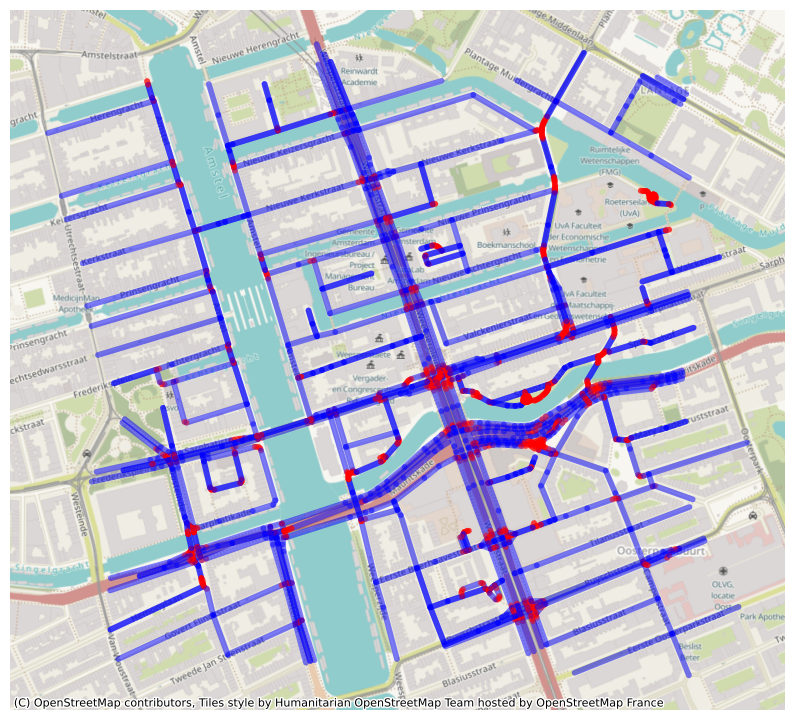

In [18]:
import contextily as ctx
#crop area to roeterseiland
streets_df_crop = streets_df.cx[121833.302478:122779.132399, 485574.057764:486541.120493]

#plot with contextily (give streets a small buffer, make a new df)
streets_df_crop['geometry'] = streets_df_crop['geometry'].buffer(5)
#if the street is bottom 75%, make it red
streets_df_crop['color'] = np.where(streets_df_crop['length'] < streets_df_crop['length'].quantile(0.5), 'red', 'blue')
ax = streets_df_crop.plot(figsize=(10, 10), alpha=0.5, color=streets_df_crop['color'])
ctx.add_basemap(ax, crs=streets_df_crop.crs)
ax.set_axis_off()
plt.show()


In [ ]:
#pickle the df
streets_df.to_pickle("streets_df.pkl")

In [ ]:
#load pickle
streets_df = pd.read_pickle("streets_df.pkl")
len(streets_df)

We noticed that our geometry was cluttered with tiny streets that just look like little dots on the map. This often happens at corners or bends, but we don't really need them in our data for now.

In [19]:
#remove streets in bottom half of lengths
streets_df = streets_df[streets_df['length'] > streets_df['length'].median()]
len(streets_df)

244913

Plot an example

c:\Users\Sahir\anaconda3\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


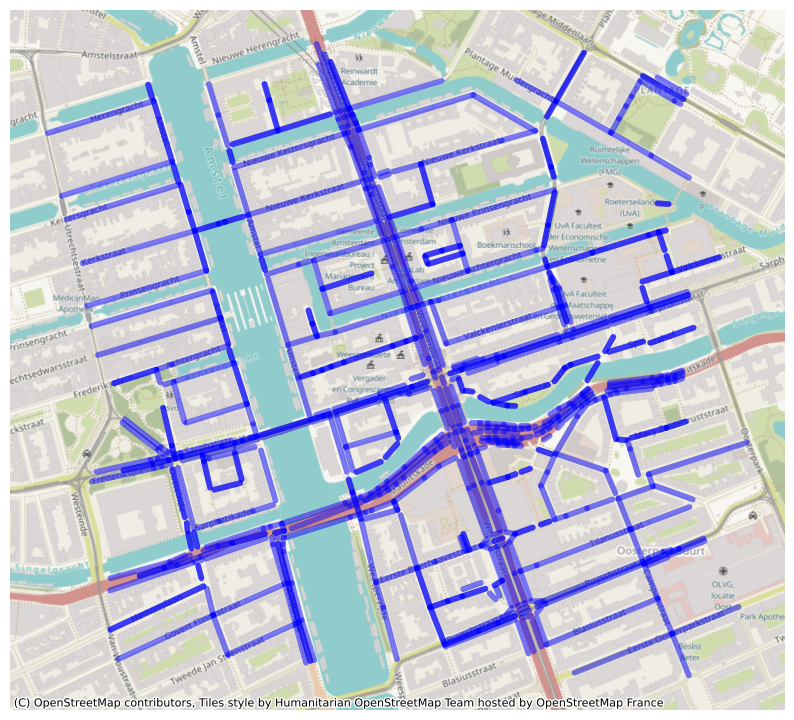

In [20]:
import contextily as ctx
#crop area to roeterseiland
streets_df_crop = streets_df.cx[121833.302478:122779.132399, 485574.057764:486541.120493]

#plot with contextily (give streets a small buffer, make a new df)
streets_df_crop['geometry'] = streets_df_crop['geometry'].buffer(5)

ax = streets_df_crop.plot(figsize=(10, 10), alpha=0.5, color='blue')
ctx.add_basemap(ax, crs=streets_df_crop.crs)
ax.set_axis_off()
plt.show()


#### 3.1 Estimating width

In [21]:
#we will use a random forest regressor to predict the width of the street
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
tqdm.pandas()


#we will use the following features: oneway, highway, surface, lit, smoothness, reversed, length, maxspeed, geometry
X = streets_df[["oneway", "highway", "surface", "lit", "smoothness", "reversed", "length", "maxspeed", "geometry"]]
y = streets_df["width"]

#maxspeed to numeric
X["maxspeed"] = pd.to_numeric(X["maxspeed"], errors="coerce")

#geometry column to point
X["geometry"] = X["geometry"].apply(lambda x: x.centroid)

#get distance from Amsterdam centraal station for each point
amsterdam_centraal = (52.379128, 4.899788)
X["distance"] = X["geometry"].progress_apply(lambda x: ox.distance.great_circle_vec(amsterdam_centraal[0], amsterdam_centraal[1], x.y, x.x))

#drop geometry column
X = X.drop(columns=["geometry"])

#impute missing values
X["maxspeed"] = X["maxspeed"].fillna(X["maxspeed"].mean())
X["surface"] = X["surface"].fillna(X["surface"].mode()[0])
X["lit"] = X["lit"].fillna(X["lit"].mode()[0])
X["smoothness"] = X["smoothness"].fillna(X["smoothness"].mode()[0])
X["reversed"] = X["reversed"].fillna(X["reversed"].mode()[0])
X["highway"] = X["highway"].fillna(X["highway"].mode()[0])
X["oneway"] = X["oneway"].fillna(X["oneway"].mode()[0])
X["length"] = X["length"].fillna(X["length"].mean())

#one hot encode all non-numeric features
X = pd.get_dummies(X, columns=["surface", "lit", "smoothness", "reversed", "highway", "oneway"])

#scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

#save X to disk
np.save("X.npy", X)

#convert y to numerical
y = pd.to_numeric(y, errors="coerce")

#save y to disk
np.save("y.npy", y)

c:\Users\Sahir\anaconda3\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Sahir\anaconda3\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  0%|          | 0/244913 [00:00<?, ?it/s]

C:\Users\Sahir\AppData\Local\Temp\ipykernel_15652\2476256245.py:22: UserWarning: The `great_circle_vec` function has been renamed `great_circle`. Calling `great_circle_vec` will raise an error in a future release.
  X["distance"] = X["geometry"].progress_apply(lambda x: ox.distance.great_circle_vec(amsterdam_centraal[0], amsterdam_centraal[1], x.y, x.x))
c:\Users\Sahir\anaconda3\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [29]:
#load X from disk
X = np.load("X.npy")

#load y from disk
y = np.load("y.npy")

#drop Nan rows
X = X[~np.isnan(y)]
y = y[~np.isnan(y)]


#fill nan in X and Y
X = np.nan_to_num(X)
y = np.nan_to_num(y)


#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#train a random forest regressor
model = RandomForestRegressor(n_jobs=-1, )
model.fit(X_train, y_train)


#predict
y_pred = model.predict(X_test)

#calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)



0.6628715122348938


In [39]:
#visualise some of the results in a table
df = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})

#add a header to the df 'predicted width' vs actual width
df.columns = ["actual width", "predicted width"]
df.head(4)


actual width  predicted width
0          1.75           2.1900
1          2.00           2.6295
2          5.00           5.4525
3          3.00           3.3050

In [40]:
#apply the width predictor to the whole dataset

#we can just load X from disk
X = np.load("X.npy")

#predict
y_pred = model.predict(X)

#save to df
streets_df["width_predicted"] = y_pred



#### 3.2 Predicting surface

In [41]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
tqdm.pandas()

#load pickle

#we will use the following features: oneway, highway, width, lit, smoothness, reversed, length, maxspeed, geometry
X = streets_df[["oneway", "highway", "width", "lit", "smoothness", "reversed", "length", "maxspeed", "geometry"]]
y = streets_df["surface"]

#maxspeed to numeric
X["maxspeed"] = pd.to_numeric(X["maxspeed"], errors="coerce")

#width to numeric
X["width"] = pd.to_numeric(X["width"], errors="coerce")

#geometry column to point
X["geometry"] = X["geometry"].apply(lambda x: x.centroid)

#get distance from Amsterdam centraal station for each point
amsterdam_centraal = (52.379128, 4.899788)
X["distance"] = X["geometry"].progress_apply(lambda x: ox.distance.great_circle_vec(amsterdam_centraal[0], amsterdam_centraal[1], x.y, x.x))

#drop geometry column
X = X.drop(columns=["geometry"])

#impute missing values
X["maxspeed"] = X["maxspeed"].fillna(X["maxspeed"].mean())
X["lit"] = X["lit"].fillna(X["lit"].mode()[0])
X["smoothness"] = X["smoothness"].fillna(X["smoothness"].mode()[0])
X["reversed"] = X["reversed"].fillna(X["reversed"].mode()[0])
X["highway"] = X["highway"].fillna(X["highway"].mode()[0])
X["oneway"] = X["oneway"].fillna(X["oneway"].mode()[0])
X["length"] = X["length"].fillna(X["length"].mean())
X["width"] = X["width"].fillna(X["width"].mean())

#one hot encode all non-numeric features
X = pd.get_dummies(X, columns=["lit", "smoothness", "reversed", "highway", "oneway"])

#scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

#save X to disk
np.save("X.npy", X)

#save y
np.save("y.npy", y)




c:\Users\Sahir\anaconda3\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Sahir\anaconda3\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  0%|          | 0/244913 [00:00<?, ?it/s]

C:\Users\Sahir\AppData\Local\Temp\ipykernel_15652\134553263.py:22: UserWarning: The `great_circle_vec` function has been renamed `great_circle`. Calling `great_circle_vec` will raise an error in a future release.
  X["distance"] = X["geometry"].progress_apply(lambda x: ox.distance.great_circle_vec(amsterdam_centraal[0], amsterdam_centraal[1], x.y, x.x))
c:\Users\Sahir\anaconda3\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
tqdm.pandas()

#load X from disk
X = np.load("X.npy")
#load y from disk
y = np.load("y.npy", allow_pickle=True)

#convert to string
y = y.astype(str)

#remove 'nan' values
X = X[y != 'nan']
y = y[y != 'nan']


#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#train the random forest regressor model
model = RandomForestClassifier(n_jobs=-1, )
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

#calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7323088420757625


In [46]:
#print some predictions in a table

df = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})

#add a header to the df 'predicted width' vs actual width
df.columns = ["actual surface", "predicted surface"]
#print random rows
df.sample(4)


actual surface predicted surface
13973         ground           asphalt
10280        asphalt           asphalt
4259         asphalt           asphalt
5434   paving_stones     paving_stones

In [ ]:
#apply the surface predictor to the whole dataset

#we can just load X from disk
X = np.load("X.npy")

#predict
y_pred = model.predict(X)

#save to df
streets_df["surface_predicted"] = y_pred

#save to pickle
streets_df.to_pickle("streets_df_width_surface_predicted.pkl")

#### 3.3 re-clean our data

In [2]:
streets_df = pd.read_pickle("streets_df_width_surface_predicted.pkl")

#replace nan in width with predicted width
streets_df["width"] = streets_df["width"].fillna(streets_df["width_predicted"])

#replace nan in surface with predicted surface
streets_df["surface"] = streets_df["surface"].fillna(streets_df["surface_predicted"])

#drop width_predicted and surface_predicted
streets_df = streets_df.drop(columns=["width_predicted", "surface_predicted"])

streets_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 242475 entries, (6316199, 46388769, 0) to (11415605724, 11415605723, 0)
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   osmid       242475 non-null  int64   
 1   oneway      242475 non-null  bool    
 2   highway     242475 non-null  object  
 3   name        152358 non-null  object  
 4   width       242475 non-null  object  
 5   surface     242475 non-null  object  
 6   lit         53338 non-null   object  
 7   smoothness  50298 non-null   object  
 8   reversed    242475 non-null  bool    
 9   length      242475 non-null  float64 
 10  maxspeed    89952 non-null   object  
 11  lanes       26826 non-null   object  
 12  est_width   328 non-null     object  
 13  area        16 non-null      object  
 14  geometry    242475 non-null  geometry
dtypes: bool(2), float64(1), geometry(1), int64(1), object(10)
memory usage: 30.5+ MB


<a id=4></a>
### 4. Building polygons for ways

In [3]:
#calculate the scale factor to convert the width from meters to seconds
def scale_factor(length, geom_length):
    return length/geom_length

def makePolygon(row):
    
    try:
        width = float(row['width'])
    except:
        width = 1
    scale = scale_factor(row['length'], row['geometry'].length)
    scaled_width = width / scale

    polygon = row['geometry'].buffer(scaled_width/2, cap_style='flat')
    return polygon


In [4]:
#Apply this function to the dataframe
tqdm.pandas()
streets_df['polygon'] = streets_df.progress_apply(makePolygon, axis=1)

  0%|          | 0/242475 [00:00<?, ?it/s]

In [5]:
streets_df

osmid  oneway       highway  \
u           v           key                                    
6316199     46388769    0      7372614    True   residential   
451946447   451946445   0     38297119   False  unclassified   
46388769    46389218    0      7372614    True   residential   
25596455    46356773    0     37481780   False    pedestrian   
46356773    4854477802  0      7046000   False    pedestrian   
...                                ...     ...           ...   
11415508359 11415592848 0    120804272   False      cycleway   
11415592837 11415592836 0      7380534   False  unclassified   
            11415592835 0      7380534   False  unclassified   
11415592850 11415592849 0    120804272   False      cycleway   
11415605724 11415605723 0    117773415   False      cycleway   

                                                 name   width        surface  \
u           v           key                                                    
6316199     46388769    0                      Singel    3.82  paving_stones   
451946447   451946445   0        Joes Kloppenburgbrug   5.171  paving_stones   
46388769    46389218    0                      Singel    3.39  paving_stones   
25596455    46356773    0    Wilhelmina Blombergplein  6.0495  paving_stones   
46356773    4854477802  0     Johanna ter Meulenplein   5.602          paved   
...                                               ...     ...            ...   
11415508359 11415592848 0                     Hornweg    2.00        asphalt   
11415592837 11415592836 0                    Basisweg  6.4225        asphalt   
            11415592835 0                    Basisweg  5.0685        asphalt   
11415592850 11415592849 0                     Hornweg    2.00        asphalt   
11415605724 11415605723 0                 Noordzeeweg    4.00        asphalt   

                             lit    smoothness  reversed   length maxspeed  \
u           v           key                                                  
6316199     46388769    0    yes  intermediate     False  198.768       30   
451946447   451946445   0    yes  intermediate     False   24.088       30   
46388769    46389218    0    yes  intermediate     False   26.809       30   
25596455    46356773    0    NaN           NaN      True   41.700      NaN   
46356773    4854477802  0    NaN           NaN      True   30.376      NaN   
...                          ...           ...       ...      ...      ...   
11415508359 11415592848 0    yes          good      True   24.613      NaN   
11415592837 11415592836 0    yes           NaN     False   19.782      NaN   
            11415592835 0    yes           NaN      True   21.653      NaN   
11415592850 11415592849 0    yes          good      True   17.739      NaN   
11415605724 11415605723 0    yes          good      True   26.493      NaN   

                            lanes est_width area  \
u           v           key                        
6316199     46388769    0     NaN       NaN  NaN   
451946447   451946445   0     NaN       NaN  NaN   
46388769    46389218    0     NaN       NaN  NaN   
25596455    46356773    0     NaN       NaN  NaN   
46356773    4854477802  0     NaN       NaN  NaN   
...                           ...       ...  ...   
11415508359 11415592848 0     NaN       NaN  NaN   
11415592837 11415592836 0       2       NaN  NaN   
            11415592835 0       2       NaN  NaN   
11415592850 11415592849 0     NaN       NaN  NaN   
11415605724 11415605723 0     NaN       NaN  NaN   

                                                                      geometry  \
u           v           key                                                      
6316199     46388769    0    LINESTRING (121029.232 487038.330, 121053.617 ...   
451946447   451946445   0    LINESTRING (121020.753 487039.357, 120996.729 ...   
46388769    46389218    0    LINESTRING (121053.617 487235.730, 121058.429 ...   
25596455    46356773    0    LINESTRING (123420.387 48642

In [6]:
#calculate area of each polygon
streets_df['area'] = streets_df['polygon'].area
streets_df


osmid  oneway       highway  \
u           v           key                                    
6316199     46388769    0      7372614    True   residential   
451946447   451946445   0     38297119   False  unclassified   
46388769    46389218    0      7372614    True   residential   
25596455    46356773    0     37481780   False    pedestrian   
46356773    4854477802  0      7046000   False    pedestrian   
...                                ...     ...           ...   
11415508359 11415592848 0    120804272   False      cycleway   
11415592837 11415592836 0      7380534   False  unclassified   
            11415592835 0      7380534   False  unclassified   
11415592850 11415592849 0    120804272   False      cycleway   
11415605724 11415605723 0    117773415   False      cycleway   

                                                 name   width        surface  \
u           v           key                                                    
6316199     46388769    0                      Singel    3.82  paving_stones   
451946447   451946445   0        Joes Kloppenburgbrug   5.171  paving_stones   
46388769    46389218    0                      Singel    3.39  paving_stones   
25596455    46356773    0    Wilhelmina Blombergplein  6.0495  paving_stones   
46356773    4854477802  0     Johanna ter Meulenplein   5.602          paved   
...                                               ...     ...            ...   
11415508359 11415592848 0                     Hornweg    2.00        asphalt   
11415592837 11415592836 0                    Basisweg  6.4225        asphalt   
            11415592835 0                    Basisweg  5.0685        asphalt   
11415592850 11415592849 0                     Hornweg    2.00        asphalt   
11415605724 11415605723 0                 Noordzeeweg    4.00        asphalt   

                             lit    smoothness  reversed   length maxspeed  \
u           v           key                                                  
6316199     46388769    0    yes  intermediate     False  198.768       30   
451946447   451946445   0    yes  intermediate     False   24.088       30   
46388769    46389218    0    yes  intermediate     False   26.809       30   
25596455    46356773    0    NaN           NaN      True   41.700      NaN   
46356773    4854477802  0    NaN           NaN      True   30.376      NaN   
...                          ...           ...       ...      ...      ...   
11415508359 11415592848 0    yes          good      True   24.613      NaN   
11415592837 11415592836 0    yes           NaN     False   19.782      NaN   
            11415592835 0    yes           NaN      True   21.653      NaN   
11415592850 11415592849 0    yes          good      True   17.739      NaN   
11415605724 11415605723 0    yes          good      True   26.493      NaN   

                            lanes est_width        area  \
u           v           key                               
6316199     46388769    0     NaN       NaN  760.306634   
451946447   451946445   0     NaN       NaN  125.336036   
46388769    46389218    0     NaN       NaN   91.013368   
25596455    46356773    0     NaN       NaN  253.226966   
46356773    4854477802  0     NaN       NaN  170.754058   
...                           ...       ...         ...   
11415508359 11415592848 0     NaN       NaN   49.288252   
11415592837 11415592836 0       2       NaN  127.671159   
            11415592835 0       2       NaN  110.283029   
11415592850 11415592849 0     NaN       NaN   35.562735   
11415605724 11415605723 0     NaN       NaN  106.496612   

                                                                      geometry  \
u           v           key                                                      
6316199     46388769    0    LINESTRING (121029.232 487038.330, 121053.617 ...   
451946447   451946445   0    LINESTRING (121020.753 487039.357, 120996.729 ...   
46388769    46389218    0    LINESTRING (121053.

<a id=5></a>
### 5. Building a raster cropping function

In [7]:
#make sure the bike network has the correct projection
streets_df.crs

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [8]:
def getImageCrop(image, polygon, raster):
    #check if the polygon is valid
    assert polygon.is_valid

    #if the polygon is not within the raster bounds, return None
    if polygon.bounds[0] < raster.bounds[0]:
        return None
    if polygon.bounds[1] < raster.bounds[1]:
        return None
    if polygon.bounds[2] > raster.bounds[2]:
        return None
    if polygon.bounds[3] > raster.bounds[3]:
        return None
    
    #if the area of the polygon is 0 or the polygon is type empty, return None
    if polygon.area == 0:
        return None
    if polygon.is_empty:
        return None
    
    #make a crop of the rasterwith the polygon
    crop, transform = mask(raster, [polygon], crop=True)
    crop.shape

    return crop

<a id=6></a>
### 6. Calculating values
#### 6.1 Calculate shadow proportion using extremely advanced division

In [9]:
def getShadowProportion(crop):
    #handle None (out of bounds)
    if crop is None:
        return None
    
    #normalize everything to 0, 128, 255
    crop[crop == 0] = 128
    crop[crop < 0 ] = 0
    crop[crop == 1] = 255

    #count the pixels
    pixel_counter = Counter(crop[0].flatten())

    total_pixels = pixel_counter[128] + pixel_counter[255]
    shadow_pixels = pixel_counter[255]

    #handle division by zero
    if total_pixels == 0:
        shadow_prop = 0
    else:
        shadow_prop = shadow_pixels / total_pixels
    return shadow_prop


[-3.4028235e+38  0.0000000e+00  1.0000000e+00]
shadow proportion: 26.68%


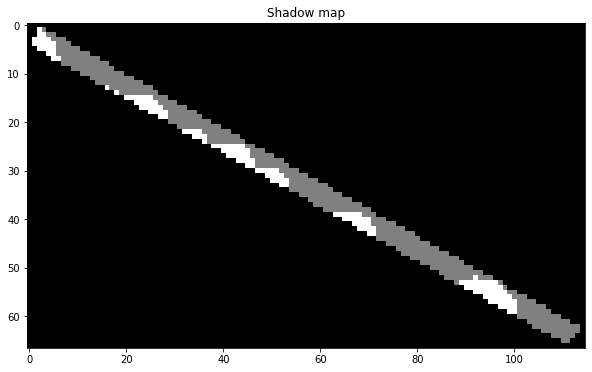

In [125]:
#Lets test our functions
test_polygon = streets_df.iloc[12].polygon
crop = getImageCrop(image, test_polygon, raster)

print(np.unique(crop))
shadow_prop = getShadowProportion(crop)
print('shadow proportion: {:.2%}'.format(shadow_prop))
#plot crop
plt.figure(figsize=(10,10))
plt.imshow(crop[0], cmap='gray', norm=colors.Normalize(vmin=0, vmax=255))
plt.title('Shadow map')
plt.show()

#### 6.2 Calculate the average perceived temperature using extremely advanced summation combined with division

In [16]:
def getAverageTemperature(crop):
    #handle None (out of bounds)
    if crop is None:
        return None
    
    #count the pixels
    pixel_counter = Counter(crop[0].flatten())

    # remove the outlier
    del pixel_counter[255]

    # check if the pixel counter is empty
    if len(pixel_counter) == 0:
        return None
    else:
        # average temperature
        sum = 0
        for temp in pixel_counter:
            sum += temp * pixel_counter[temp]
        average_temp = sum / np.sum(list(pixel_counter.values()))
        average_temp
    
    return average_temp

Average temperature: 42.88 degrees Celsius


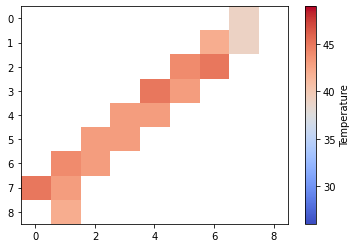

In [36]:
# get a crop of the image
crop = getImageCrop(temp_image, streets_df.iloc[40].polygon, temp_raster)

# Setting temperature range
temp_min = 26
temp_max = 49

# Handling the outlier (255) as a special case by setting it to NaN
crop_without_outlier = np.where(crop == 255, np.nan, crop)

# calculate the average temperature
avg_temp = getAverageTemperature(crop)
print(f'Average temperature: {avg_temp:.2f} degrees Celsius')

# Display the cropped image without normalization, handling the outlier
plt.imshow(crop_without_outlier[0], cmap='coolwarm', aspect='auto', vmin=temp_min, vmax=temp_max)
plt.colorbar(label='Temperature')
plt.show()

#### 6.3 Calculate the average urban heat island effect

In [48]:
def getUHI(crop):
    if crop is None:
        return None
    
    #count the pixels
    pixel_counter = Counter(crop[0].flatten())

    # remove the outlier
    del pixel_counter[-9.999e+03]

    # check if the pixel counter is empty
    if len(pixel_counter) == 0:
        return None
    else:
        # average UHI effect
        sum = 0
        for uhi in pixel_counter:
            sum += uhi * pixel_counter[uhi]
        average_uhi = sum / np.sum(list(pixel_counter.values()))

    return average_uhi

UHI effect: 2.20
[-9.999e+03  2.088e+00  2.094e+00  2.169e+00  2.181e+00  2.202e+00
  2.228e+00  2.241e+00  2.251e+00  2.260e+00  2.268e+00]


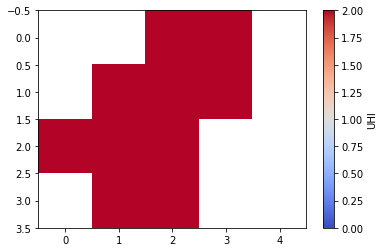

In [53]:
polygon = streets_df.iloc[40].polygon
buffered_polygon = polygon.buffer(10)

crop = getImageCrop(uhi_image, buffered_polygon, uhi_raster)
print(f'UHI effect: {getUHI(crop):.2f}')

# concert to np array
crop = np.array(crop)
print(np.unique(crop))

# Handling the outlier (255) as a special case by setting it to NaN
crop_without_outlier = np.where(crop == -9.999e+03, np.nan, crop)

min_effect = 0 
max_effect = 2

# Display the cropped image without normalization, handling the outlier
plt.imshow(crop_without_outlier[0], cmap='coolwarm', aspect='auto', vmin=min_effect, vmax=max_effect)
plt.colorbar(label='UHI')
plt.show()


<a id=7></a>
### 7. Apply our functions to the dataframe!

In [54]:
#loop em 
#make a column for the new featurea
streets_df['shadow_prop'] = np.nan
streets_df['avg_temperature'] = np.nan
streets_df['uhi'] = np.nan

#refactor to a function for multiprocessing
def getShadowProportionMultiprocessing(row):
    polygon = row['polygon']
    crop = getImageCrop(image, polygon, raster)
    shadow_prop = getShadowProportion(crop)
    return shadow_prop

def getAverageTemperatureMultiprocessing(row):
    polygon = row['polygon']
    crop = getImageCrop(temp_image, polygon, temp_raster)
    avg_temp = getAverageTemperature(crop)
    return avg_temp

def getUHIMultiprocessing(row):
    polygon = row['polygon']
    
    #buffer the polygon to get a better estimate of the UHI effect
    buffered_polygon = polygon.buffer(10)
    crop = getImageCrop(uhi_image, buffered_polygon, uhi_raster)
    uhi = getUHI(crop)
    return uhi

#apply the functions to the dataframe
streets_df['shadow_prop'] = streets_df.progress_apply(getShadowProportionMultiprocessing, axis=1)
streets_df['avg_temperature'] = streets_df.progress_apply(getAverageTemperatureMultiprocessing, axis=1)
streets_df['uhi'] = streets_df.progress_apply(getUHIMultiprocessing, axis=1)


  0%|          | 0/242475 [00:00<?, ?it/s]

  0%|          | 0/242475 [00:00<?, ?it/s]

  0%|          | 0/242475 [00:00<?, ?it/s]

### Lets pickle the dataframe for later use

##### And make a cool graph!

In [100]:
#deep copy the dataframe to manipulate it 
bike_network = streets_df.copy(deep=True)

bike_network.drop(columns=["geometry"], inplace=True)
bike_network.rename(columns={"polygon": "geometry"}, inplace=True)
bike_network

osmid  oneway       highway  \
u           v           key                                    
6316199     46388769    0      7372614    True   residential   
451946447   451946445   0     38297119   False  unclassified   
46388769    46389218    0      7372614    True   residential   
25596455    46356773    0     37481780   False    pedestrian   
46356773    4854477802  0      7046000   False    pedestrian   
...                                ...     ...           ...   
11415508359 11415592848 0    120804272   False      cycleway   
11415592837 11415592836 0      7380534   False  unclassified   
            11415592835 0      7380534   False  unclassified   
11415592850 11415592849 0    120804272   False      cycleway   
11415605724 11415605723 0    117773415   False      cycleway   

                                                 name   width        surface  \
u           v           key                                                    
6316199     46388769    0                      Singel    3.82  paving_stones   
451946447   451946445   0        Joes Kloppenburgbrug   5.171  paving_stones   
46388769    46389218    0                      Singel    3.39  paving_stones   
25596455    46356773    0    Wilhelmina Blombergplein  6.0495  paving_stones   
46356773    4854477802  0     Johanna ter Meulenplein   5.602          paved   
...                                               ...     ...            ...   
11415508359 11415592848 0                     Hornweg    2.00        asphalt   
11415592837 11415592836 0                    Basisweg  6.4225        asphalt   
            11415592835 0                    Basisweg  5.0685        asphalt   
11415592850 11415592849 0                     Hornweg    2.00        asphalt   
11415605724 11415605723 0                 Noordzeeweg    4.00        asphalt   

                             lit    smoothness  reversed   length maxspeed  \
u           v           key                                                  
6316199     46388769    0    yes  intermediate     False  198.768       30   
451946447   451946445   0    yes  intermediate     False   24.088       30   
46388769    46389218    0    yes  intermediate     False   26.809       30   
25596455    46356773    0    NaN           NaN      True   41.700      NaN   
46356773    4854477802  0    NaN           NaN      True   30.376      NaN   
...                          ...           ...       ...      ...      ...   
11415508359 11415592848 0    yes          good      True   24.613      NaN   
11415592837 11415592836 0    yes           NaN     False   19.782      NaN   
            11415592835 0    yes           NaN      True   21.653      NaN   
11415592850 11415592849 0    yes          good      True   17.739      NaN   
11415605724 11415605723 0    yes          good      True   26.493      NaN   

                            lanes est_width        area  \
u           v           key                               
6316199     46388769    0     NaN       NaN  760.306634   
451946447   451946445   0     NaN       NaN  125.336036   
46388769    46389218    0     NaN       NaN   91.013368   
25596455    46356773    0     NaN       NaN  253.226966   
46356773    4854477802  0     NaN       NaN  170.754058   
...                           ...       ...         ...   
11415508359 11415592848 0     NaN       NaN   49.288252   
11415592837 11415592836 0       2       NaN  127.671159   
            11415592835 0       2       NaN  110.283029   
11415592850 11415592849 0     NaN       NaN   35.562735   
11415605724 11415605723 0     NaN       NaN  106.496612   

                                                                      geometry  \
u           v           key                                                      
6316199     46388769    0    POLYGON ((121051.720 487235.965, 121055.513 48...   
451946447   451946445   0    POLYGON ((120996.451 487039.369, 120997.008 48...   
46388769    46389218    0    POLYGON ((121056.76

In [102]:
# save to pickle
bike_network.to_pickle("bike_network.pkl")

/Users/tom/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


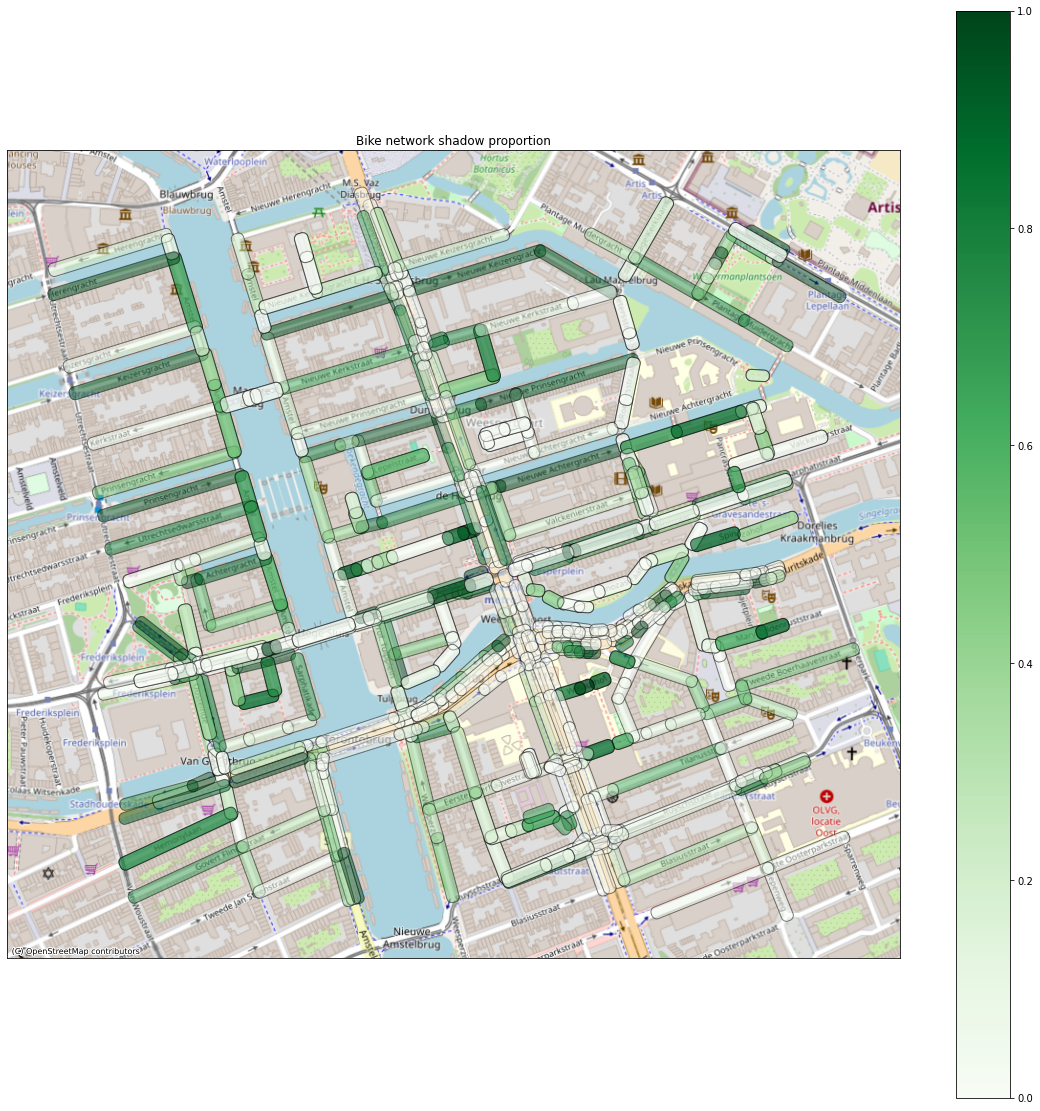

In [103]:
import contextily as ctx

#crop the bike network polygons to area around roeterseilandcampus
bike_network_crop = bike_network.cx[121833.302478:122779.132399, 485574.057764:486541.120493]
#
# bike_network_crop = bike_network.cx[119833.302478:120779.132399, 485574.057764:486541.120493]
#make all the polygons thicker
bike_network_crop.geometry = bike_network_crop.geometry.buffer(8)


#plot the bike network with the shadow proportions as color
#background as beige, color scale greens
fig, ax = plt.subplots(figsize=(20,20))
bike_network_crop.plot(column='shadow_prop', cmap='Greens', ax=ax, legend=True, alpha=0.5, edgecolor='black')
#add a basemap 

ctx.add_basemap(ax, crs='epsg:28992', source=ctx.providers.OpenStreetMap.Mapnik)
#add titles
ax.set_title('Bike network shadow proportion')
#remove ticks
ax.set_xticks([])
ax.set_yticks([])
#shrink colorbar

plt.show()


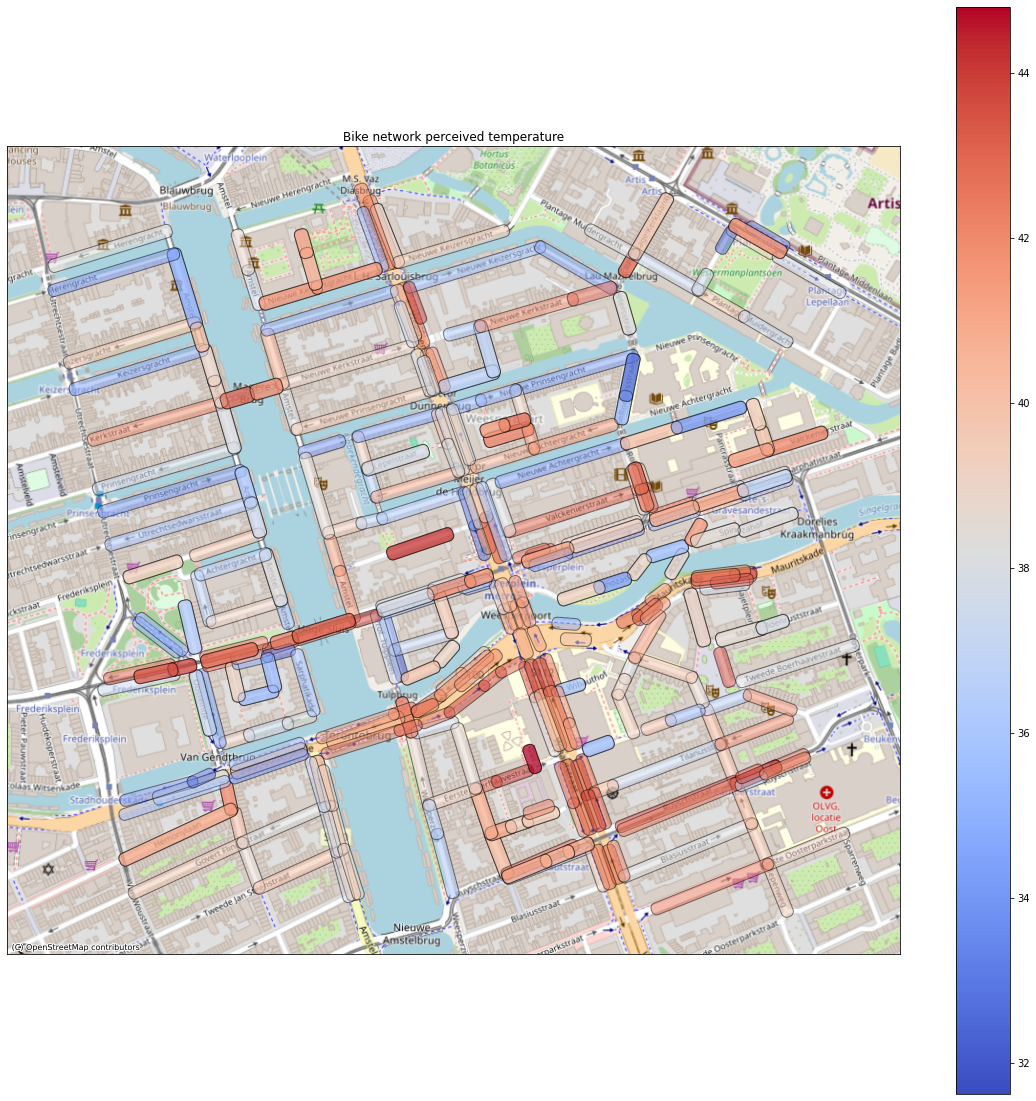

In [83]:
#plot the bike network with the shadow proportions as color
#background as beige, color scale greens
fig, ax = plt.subplots(figsize=(20,20))
bike_network_crop.plot(column='avg_temperature', cmap='coolwarm', ax=ax, legend=True, alpha=0.5, edgecolor='black')
#add a basemap 

ctx.add_basemap(ax, crs='epsg:28992', source=ctx.providers.OpenStreetMap.Mapnik)
#add titles
ax.set_title('Bike network perceived temperature')
#remove ticks
ax.set_xticks([])
ax.set_yticks([])
#shrink colorbar

plt.show()